In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
from tqdm.autonotebook import tqdm
tqdm.pandas(desc='Progress bar', leave=False)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier  
from sklearn.neural_network import MLPClassifier 
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from yellowbrick.target import ClassBalance
from yellowbrick.target import BalancedBinningReference
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.contrib.classifier import DecisionViz
from mlxtend.plotting import plot_decision_regions
import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':100})

<ipython-input-1-6ba959c0940e>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/ellemafa/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Random seed

In [2]:
seed = 123

## Read in the datasets

In [3]:
# path to save the precleaned csv file
df = pd.read_csv('FRL_Step_2_full_features_news_cleaned_2018_02_13.csv')
df.head()

,domain,title,content,content_affin,c_word_count,t_word_count,c_character_count,t_character_count,c_avg_word_length,t_avg_word_length,title_sentiment_label,title_sentiment_score,label
0,nytimes,stem cell breakthrough,stunning announcement japanese american resear...,-0.001577,154,3,1084,20,7.038961,6.666667,neutral,0.0,real
1,nytimes,quotation day,halfway lunatic terrorist line petty crime qae...,-0.091603,18,2,114,12,6.333333,6.000000,neutral,0.0,real
2,nytimes,celebrating sound rooted gritty fertile new turf,jew manhattan new york city boat jew arrived n...,0.009639,214,7,1416,42,6.616822,6.000000,positive,0.0,real
3,nytimes,apple pay tax,editor apple sidestep billion tax ieconomy ser...,0.022202,142,3,907,11,6.387324,3.666667,neutral,0.0,real
4,nytimes,katharine shergalis thomas ewald,katharine winnifred shergalis daughter mr edwa...,-0.001033,130,4,827,29,6.361538,7.250000,neutral,0.0,real


In [4]:
# checking missing values
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [5]:
missing_value(df)

,Total,Percent
title,7805,0.436162
content,4,0.000224
label,0,0.000000
title_sentiment_score,0,0.000000
title_sentiment_label,0,0.000000
t_avg_word_length,0,0.000000
c_avg_word_length,0,0.000000
t_character_count,0,0.000000
c_character_count,0,0.000000
t_word_count,0,0.000000


In [6]:
df.dropna(inplace=True)
missing_value(df)

,Total,Percent
label,0,0.0
title_sentiment_score,0,0.0
title_sentiment_label,0,0.0
t_avg_word_length,0,0.0
c_avg_word_length,0,0.0
t_character_count,0,0.0
c_character_count,0,0.0
t_word_count,0,0.0
c_word_count,0,0.0
content_affin,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781665 entries, 0 to 1789473
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   domain                 object 
 1   title                  object 
 2   content                object 
 3   content_affin          float64
 4   c_word_count           int64  
 5   t_word_count           int64  
 6   c_character_count      int64  
 7   t_character_count      int64  
 8   c_avg_word_length      float64
 9   t_avg_word_length      float64
 10  title_sentiment_label  object 
 11  title_sentiment_score  float64
 12  label                  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 190.3+ MB


## Feature engineering and vectorization

The data contains heterogeneous data types, there are  numerical, categorical  and text data. Different vectorization method was used to transform the data in those different columns.

 `one-hot encoding` for all categorical features, `robustscaler` for numeric  and `tfidfvectorizer` for the text features.

`ColumnTransformer` was used to combine all those transformations.

In [8]:
#Convert `domain` to category data type.
df['domain'] = df['domain'].astype('category')

## Features and target variables

In [9]:
df.columns

Index(['domain', 'title', 'content', 'content_affin', 'c_word_count',
       't_word_count', 'c_character_count', 't_character_count',
       'c_avg_word_length', 't_avg_word_length', 'title_sentiment_label',
       'title_sentiment_score', 'label'],
      dtype='object')

In [19]:
target = df.label
features = df[['domain', 'title', 'content', 'content_affin', 'c_word_count',
       't_word_count', 'c_character_count', 't_character_count',
       'c_avg_word_length', 't_avg_word_length', 'title_sentiment_label']].copy()

## Split the data in training and test sets

In [ ]:
#recommend c
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=seed)
print(df.shape); print(X_train.shape); print(X_test.shape)

In [73]:
#recommend making copy in the event kernel
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=seed)
print(df.shape); print(X_train.shape); print(X_test.shape)

(1781665, 13)
(1425332, 11)
(356333, 11)


## Checking the distribution of classes in the target

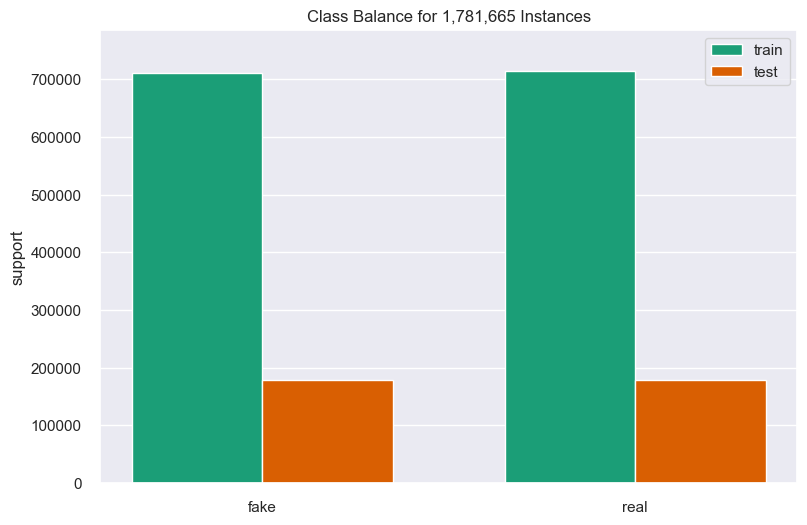

In [21]:
viz = ClassBalance(labels=['fake','real'])
viz.fit(y_train, y_test)
viz.show();

## Applying ColumnTransformer

In [74]:
# defining the numerical, categorical and textual features
numerical = ['c_word_count', 'c_avg_word_length', 'c_character_count', 't_word_count','t_avg_word_length', 't_character_count']
negative_values = ['content_affin']
categorical = ['domain', 'title_sentiment_label']
textual = ['title','content']

In [75]:
#Important:  pass the columns as string to CountVectorizer/TfifVectorizer and list of columns (even list of one column) to 
# OneHotEncoding (OHE) to make it work
# min max https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#robust https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

%%time

ct = ColumnTransformer(
    [('num', MinMaxScaler(), numerical),
     ('negative_values', RobustScaler(), negative_values),
     ('title_sentiment_label', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['title_sentiment_label']),
     ('domain', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['domain']),
     ('title', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'title'),
     ('content', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'content')], n_jobs=3, verbose=True)

### Column Transformer for MNB model. It is neccesary to take out "negative_valus" which includes ['content_affin'] as this feature has negative values which can not be input into MNB model

In [100]:
%%time

#Important:  pass the columns as string to CountVectorizer/TfifVectorizer and list of columns (even list of one column) to 
# OneHotEncoding (OHE) to make it work
# min max https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#robust https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
ct_mnb = ColumnTransformer(
    [('num', MinMaxScaler(), numerical),
     ('title_sentiment_label', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['title_sentiment_label']),
     ('domain', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['domain']),
     ('title', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'title'),
     ('content', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'content')], n_jobs=3, verbose=True)

## View the diagram of the column transformer

In [76]:
set_config(display='diagram')
ct

ColumnTransformer(n_jobs=3,
                  transformers=[('num', MinMaxScaler(),
                                 ['c_word_count', 'c_avg_word_length',
                                  'c_character_count', 't_word_count',
                                  't_avg_word_length', 't_character_count']),
                                ('negative_values', RobustScaler(),
                                 ['content_affin']),
                                ('title_sentiment_label',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['title_sentiment_label']),
                                ('domain',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore'),
                                 ['domain']),
                                ('title',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'title'),
                                ('content',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'content')],
                  verbose=True)

## Tranform the features into vectors

In [77]:
%%time
# Creating the feature matrix
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
print(f'Shape of Term Frequency Matrix of train: {X_train.shape}')
print(f'Shape of Term Frequency Matrix of test: {X_test.shape}')

Shape of Term Frequency Matrix of train: (1425332, 12163)
Shape of Term Frequency Matrix of test: (356333, 12163)
CPU times: user 25.6 s, sys: 1min 25s, total: 1min 50s
Wall time: 8min 27s


## Encode the target

In [78]:
%%time

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)
print(y_train.shape); print(y_test.shape)

(1425332,)
(356333,)
CPU times: user 235 ms, sys: 45 ms, total: 280 ms
Wall time: 279 ms


## The encoded classes in the target

In [79]:
classes = Encoder.classes_
classes

array(['fake', 'real'], dtype=object)

## Models training

## Instantiate and train the models

Steps will also include how to save models for future models.

https://scikit-learn.org/stable/modules/model_persistence.html#model-persistence

### LogisticRegression

In [ ]:
%%time
# Logistics regression
logreg = LogisticRegression(random_state=seed)

# Training the model 
logreg.fit(X_train, y_train)

#Predict the Test using the logistics regression
y_pred_lr = logreg.predict(X_test)



In [113]:
#save model for future use, come in handy if having to rerun any code blocks


#save
dump(logreg, 'logreg.joblib')
#load
#logreg = load('logreg.joblib') 

['logreg.joblib']

### DecisionTreeClassifier

In [90]:
%%time
# Decision tree classifier
dtc = DecisionTreeClassifier(criterion = 'gini', splitter='best', random_state=seed)
# Training the model 
dtc.fit(X_train, y_train)

#Predict the Test using decision tree 
y_pred_dtc = dtc.predict(X_test)

CPU times: user 2min 57s, sys: 4.6 s, total: 3min 2s
Wall time: 3min 3s


In [ ]:
#save model for future use, come in handy if having to rerun any code blocks

#save
dump(dtc, 'dtc.joblib')
#load
#dtc = load('dtc.joblib') 

### LinearSVC

In [95]:
%%time
# Linear SVC
lsvc = LinearSVC(C=0.01, dual=False, random_state=seed)
# Training the model 
lsvc.fit(X_train, y_train) 

#Predict the Test using linear svc
y_pred_lsvc = lsvc.predict(X_test)

CPU times: user 1min 18s, sys: 22.1 s, total: 1min 40s
Wall time: 32.8 s


In [ ]:
#save model for future use, come in handy if having to rerun any code blocks

#save
dump(lsvc, 'lsvc.joblib')
#load
#lsvc = load('lsvc.joblib') 

### RandomForestClassifier

In [31]:
%%time
# RandomForest classifier
rfc = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=seed, n_jobs=-1)
# Training the model 
rfc.fit(X_train, y_train) 

#Predict the Test using RandomForest classifier
y_pred_rfc = rfc.predict(X_test)

CPU times: user 1d 5h 8min 14s, sys: 18min 11s, total: 1d 5h 26min 25s
Wall time: 16h 24min 35s


In [ ]:
#save model for future use, come in handy if having to rerun any code blocks

#save
dump(rfc, 'rfc.joblib')
#load
#rfc = load('rfc.joblib') 

### SGDClassifier

In [69]:
%%time
# SGDClassifier
sgdc = SGDClassifier(max_iter=1500,random_state=seed)
# Training the model 
sgdc.fit(X_train, y_train) 

#Predict the Test using SGDClassifier
y_pred_sgdc = sgdc.predict(X_test)



CPU times: user 5.98 s, sys: 1.92 s, total: 7.91 s
Wall time: 7.44 s


In [ ]:
#save model for future use, come in handy if having to rerun any code blocks

#save
dump(sgdc, 'sgdc.joblib')
#load
#sgdc = load('sgdc.joblib') 

## Evaluate the fitted models

### Confusion matrix

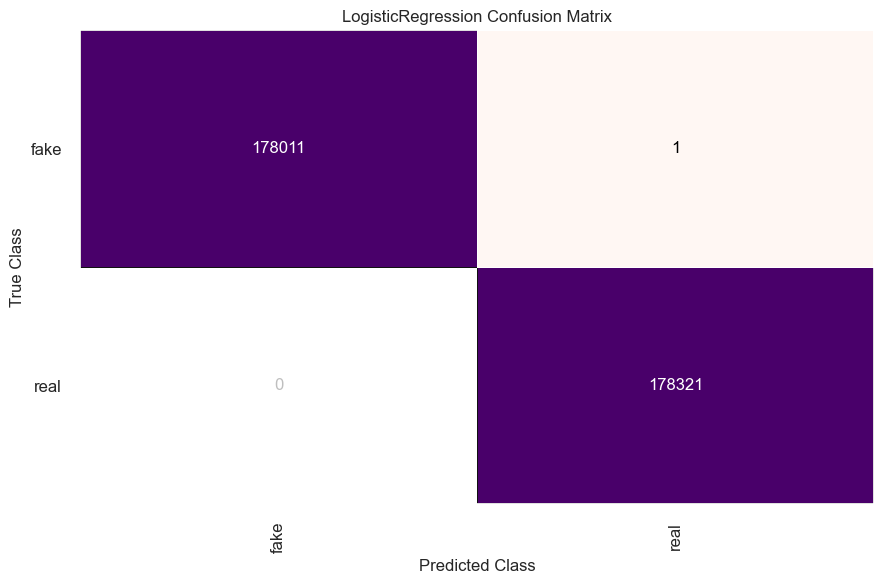

CPU times: user 1.23 s, sys: 144 ms, total: 1.37 s
Wall time: 1.5 s


<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [82]:
%%time

cm_log = ConfusionMatrix(logreg, classes=classes, cmap='RdPu')
cm_log.fit(X_train, y_train)
cm_log.score(X_test, y_test)
cm_log.show()

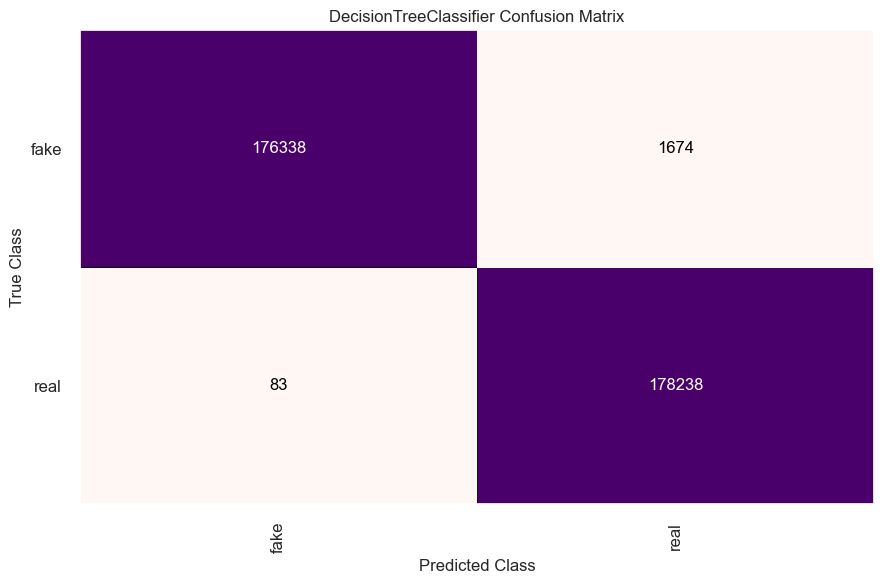

CPU times: user 1.48 s, sys: 186 ms, total: 1.67 s
Wall time: 1.65 s


<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [91]:
%%time

cm_dtc = ConfusionMatrix(dtc, classes=classes, cmap='RdPu')
cm_dtc.fit(X_train, y_train)
cm_dtc.score(X_test, y_test)
cm_dtc.show()

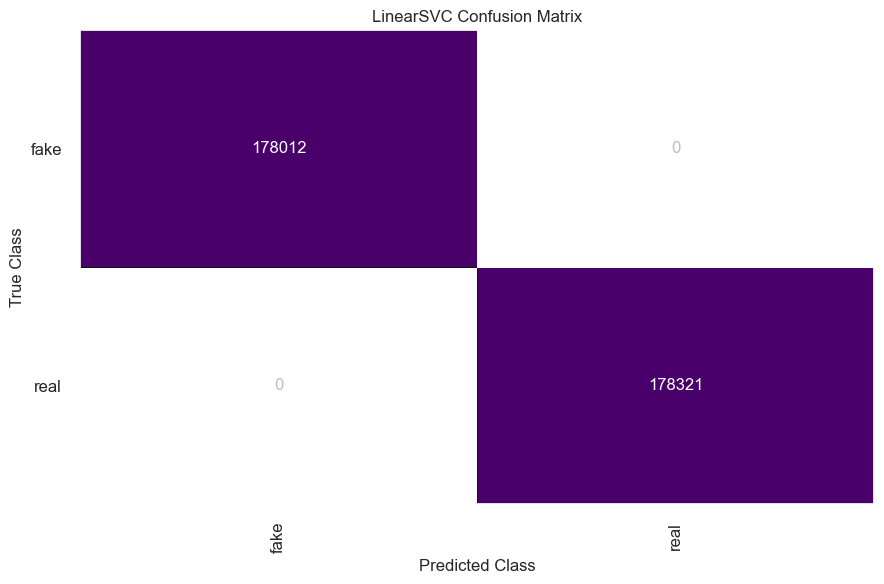

CPU times: user 1.51 s, sys: 1.04 s, total: 2.55 s
Wall time: 4.14 s


<AxesSubplot:title={'center':'LinearSVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [96]:
%%time

cm_lsvc = ConfusionMatrix(lsvc, classes=classes, cmap='RdPu')
cm_lsvc.fit(X_train, y_train)
cm_lsvc.score(X_test, y_test)
cm_lsvc.show()

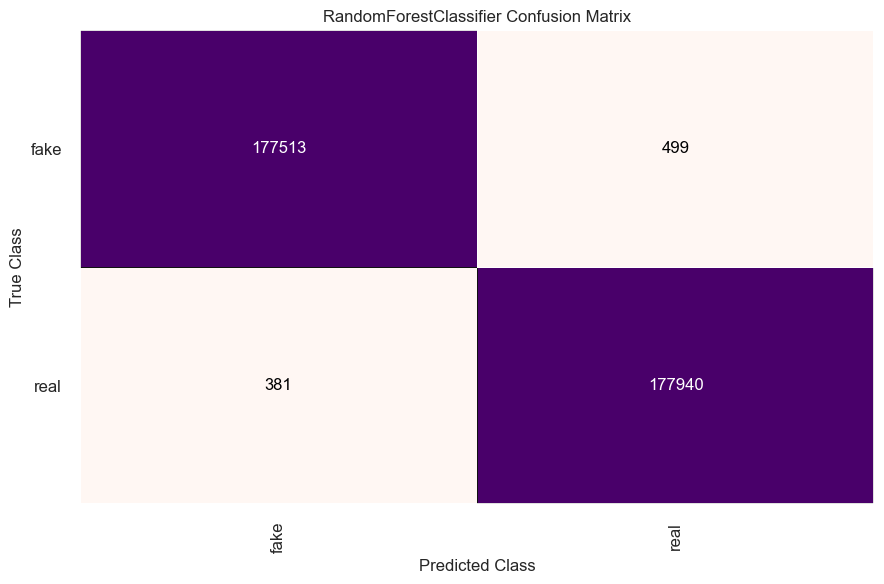

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [38]:
%%time

cm_rfc = ConfusionMatrix(rfc, classes=classes, cmap='RdPu')
cm_rfc.fit(X_train, y_train)
cm_rfc.score(X_test, y_test)
cm_rfc.show()

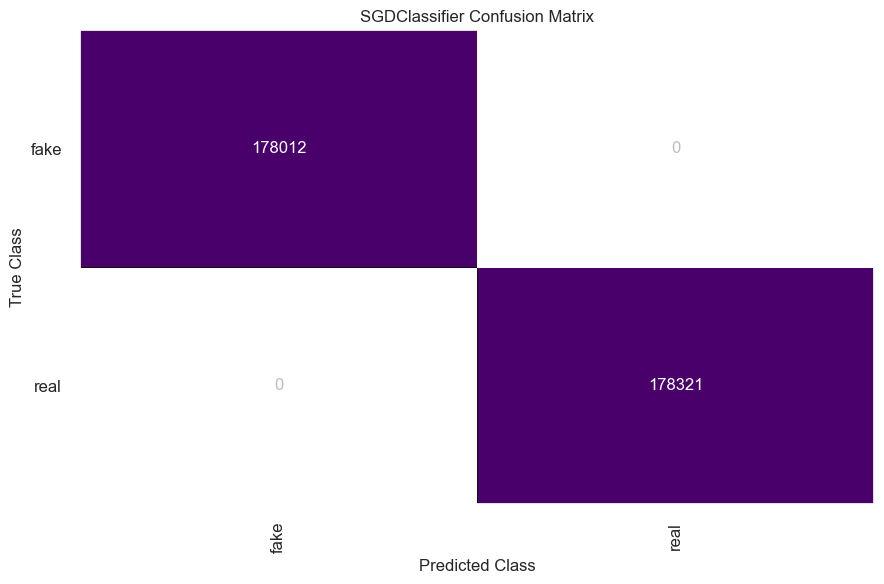

CPU times: user 1.65 s, sys: 845 ms, total: 2.49 s
Wall time: 2.93 s


<AxesSubplot:title={'center':'SGDClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [97]:
%%time

cm_sgdc = ConfusionMatrix(sgdc, classes=classes, cmap='RdPu')
cm_sgdc.fit(X_train, y_train)
cm_sgdc.score(X_test, y_test)
cm_sgdc.show()

### Classfication report

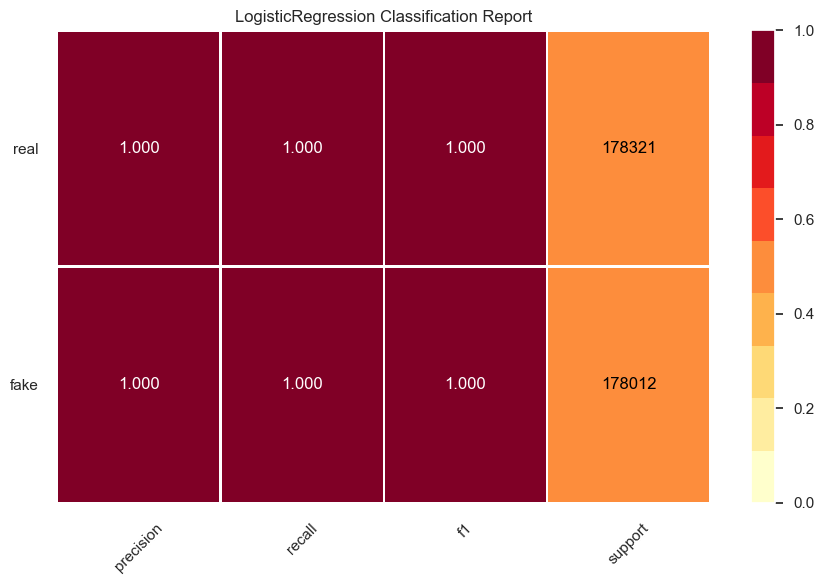

<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

In [83]:
%%time

cr_logreg = ClassificationReport(logreg, classes=classes, support=True)
cr_logreg.fit(X_train, y_train)
cr_logreg.score(X_test, y_test)
cr_logreg.show()

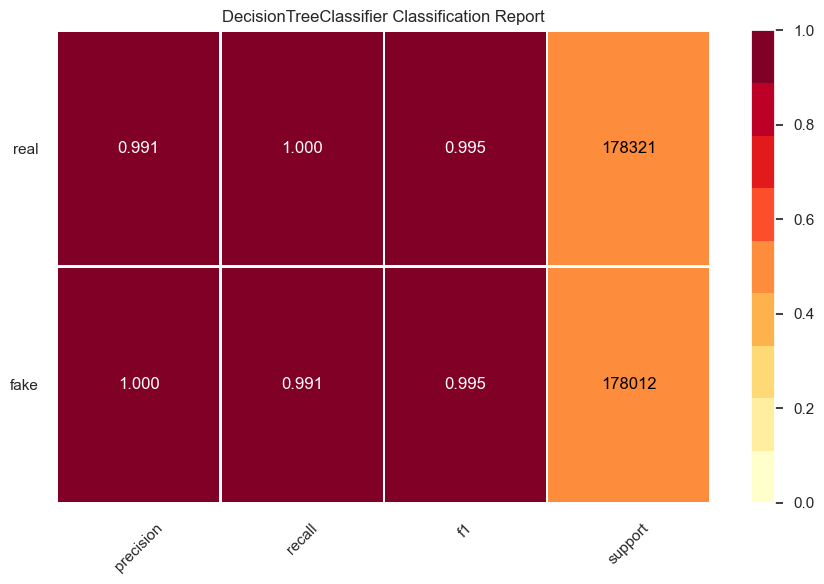

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [92]:
%%time

cr_dtc = ClassificationReport(dtc, classes=classes, support=True)
cr_dtc.fit(X_train, y_train)
cr_dtc.score(X_test, y_test)
cr_dtc.show()

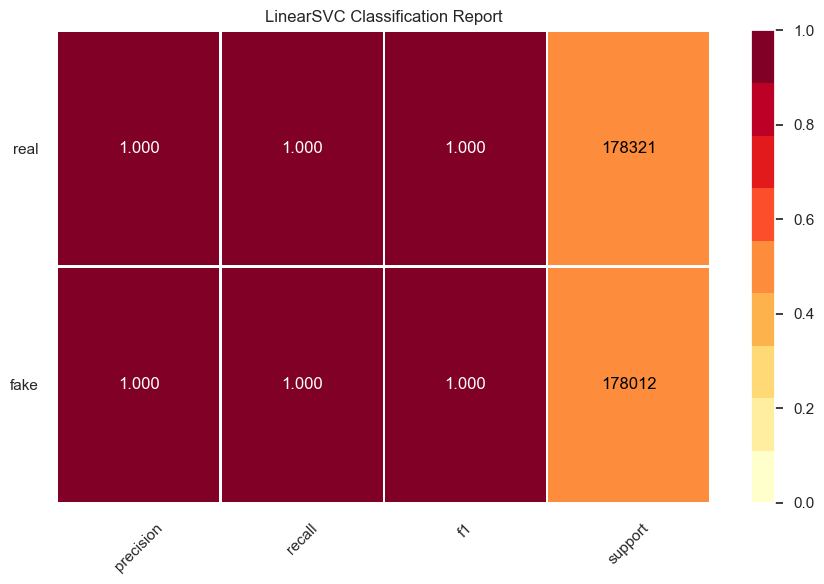

<AxesSubplot:title={'center':'LinearSVC Classification Report'}>

In [98]:
%%time

cr_lsvc = ClassificationReport(lsvc, classes=classes, support=True)
cr_lsvc.fit(X_train, y_train)
cr_lsvc.score(X_test, y_test)
cr_lsvc.show()

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 12163 

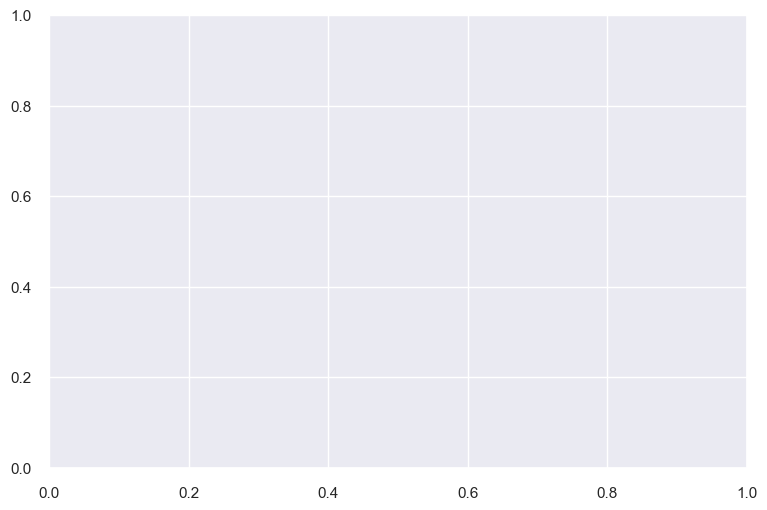

In [68]:
%%time

cr_rfc = ClassificationReport(rfc, classes=classes, support=True)
cr_rfc.fit(X_train, y_train)
cr_rfc.score(X_test, y_test)
cr_rfc.show()

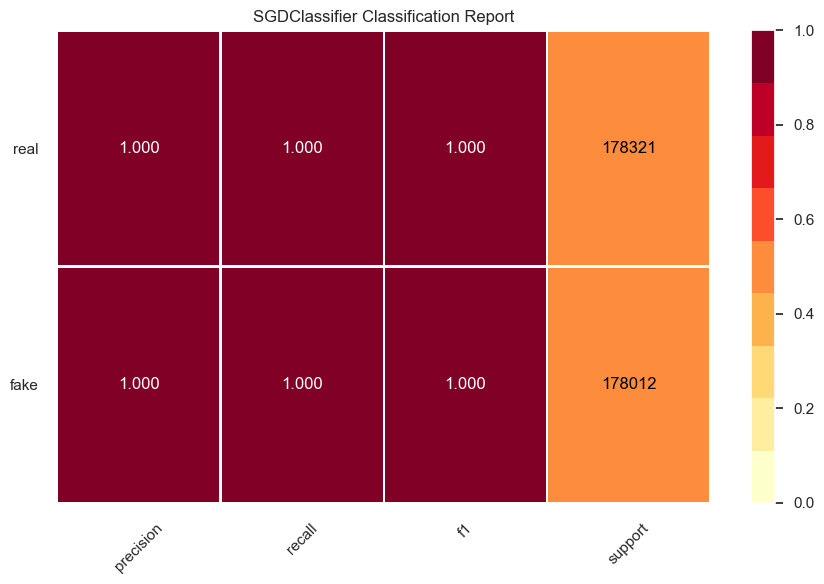

<AxesSubplot:title={'center':'SGDClassifier Classification Report'}>

In [99]:
%%time

cr_sgdc = ClassificationReport(sgdc, classes=classes, support=True)
cr_sgdc.fit(X_train, y_train)
cr_sgdc.score(X_test, y_test)
cr_sgdc.show()

In [ ]:
cr_mnb = ClassificationReport(mnb, classes=classes, support=True)
cr_mnb.fit(X_train, y_train)
cr_mnb.score(X_test, y_test)
cr_mnb.show()

### Class prediction error

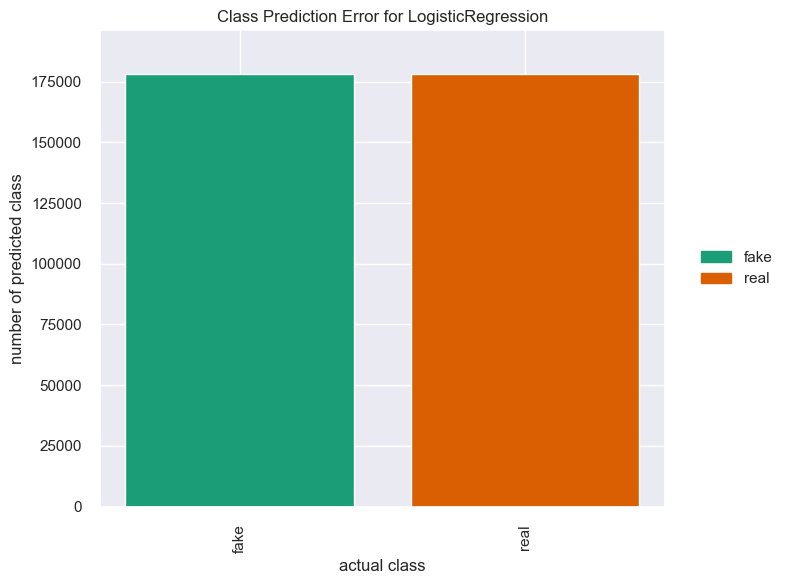

<AxesSubplot:title={'center':'Class Prediction Error for LogisticRegression'}, xlabel='actual class', ylabel='number of predicted class'>

In [41]:
cpe_logreg = ClassPredictionError(logreg, classes=classes)
cpe_logreg.fit(X_train, y_train)
cpe_logreg.score(X_test, y_test)
cpe_logreg.show()

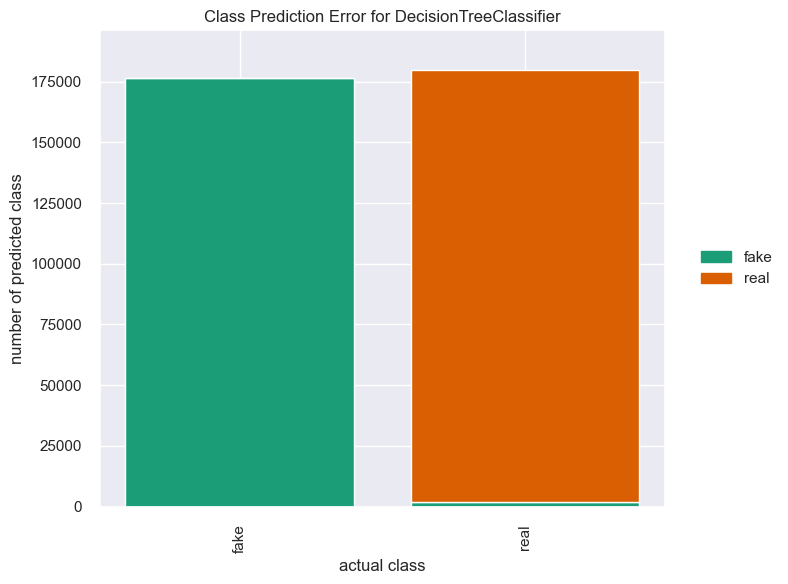

<AxesSubplot:title={'center':'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [42]:
cpe_dtc = ClassPredictionError(dtc, classes=classes)
cpe_dtc.fit(X_train, y_train)
cpe_dtc.score(X_test, y_test)
cpe_dtc.show()

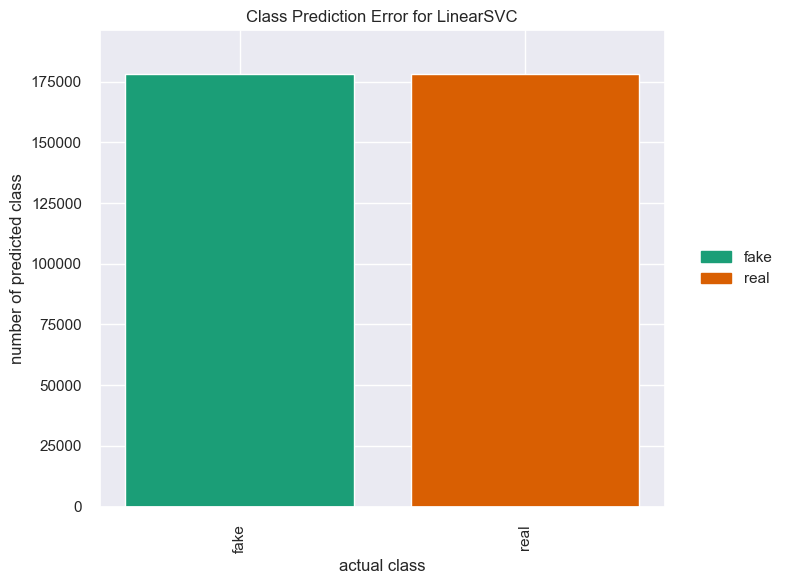

<AxesSubplot:title={'center':'Class Prediction Error for LinearSVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [43]:
cpe_lsvc = ClassPredictionError(lsvc, classes=classes)
cpe_lsvc.fit(X_train, y_train)
cpe_lsvc.score(X_test, y_test)
cpe_lsvc.show()

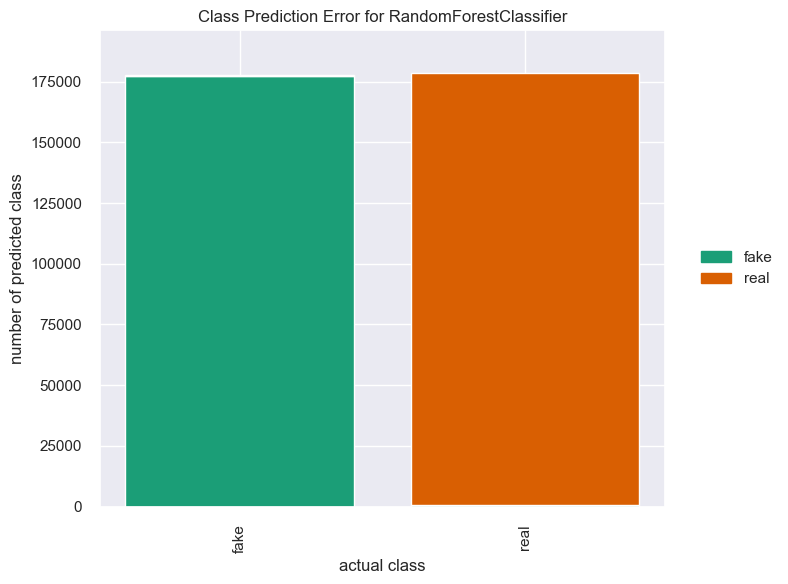

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [44]:
cpe_rfc = ClassPredictionError(rfc, classes=classes)
cpe_rfc.fit(X_train, y_train)
cpe_rfc.score(X_test, y_test)
cpe_rfc.show()

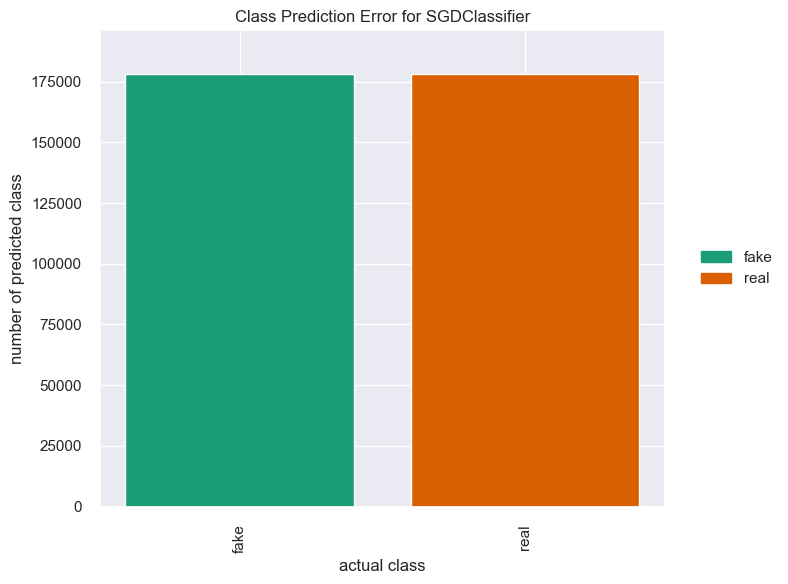

<AxesSubplot:title={'center':'Class Prediction Error for SGDClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [45]:
cpe_sgdc = ClassPredictionError(sgdc, classes=classes)
cpe_sgdc.fit(X_train, y_train)
cpe_sgdc.score(X_test, y_test)
cpe_sgdc.show()

In [ ]:
cpe_mnb = ClassPredictionError(mnb, classes=classes)
cpe_mnb.fit(X_train, y_train)
cpe_mnb.score(X_test, y_test)
cpe_mnb.show()

### ROCAUC

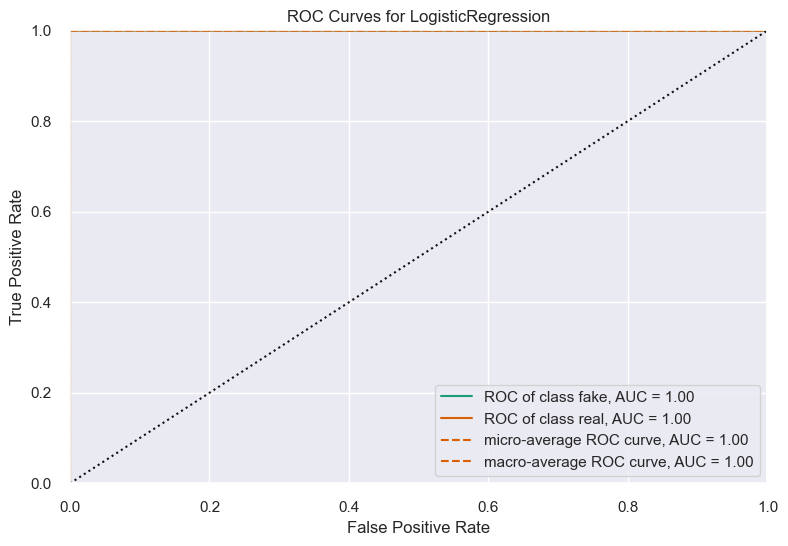

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [46]:
rocauc_logreg = ROCAUC(logreg, classes=classes)
rocauc_logreg.fit(X_train, y_train)
rocauc_logreg.score(X_test, y_test)
rocauc_logreg.show()

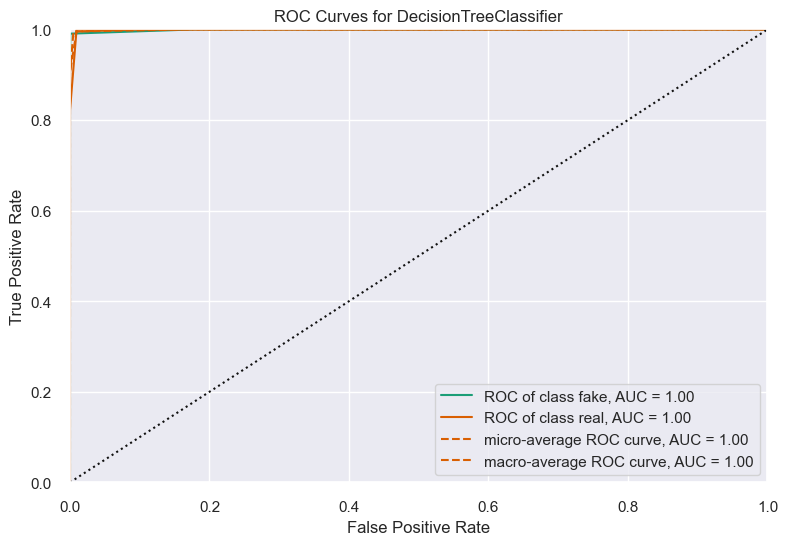

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [47]:
rocauc_dtc = ROCAUC(dtc, classes=classes)
rocauc_dtc.fit(X_train, y_train)
rocauc_dtc.score(X_test, y_test)
rocauc_dtc.show()

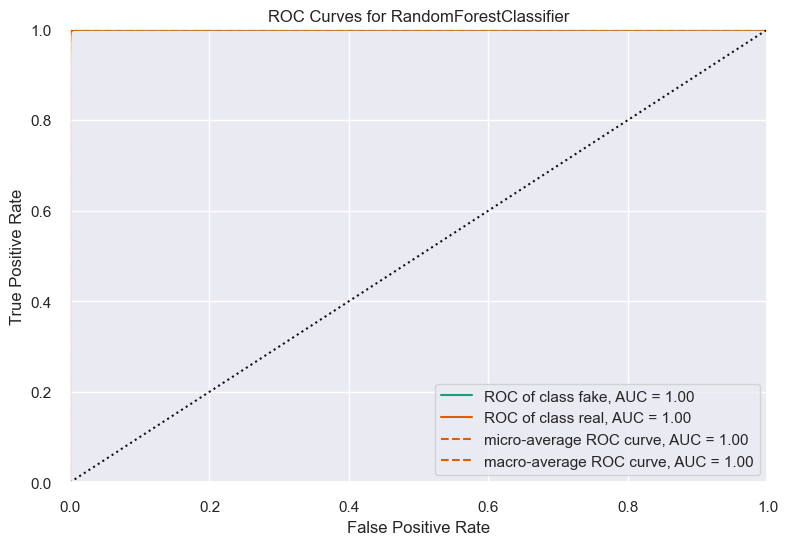

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
rocauc_rfc = ROCAUC(rfc, classes=classes)
rocauc_rfc.fit(X_train, y_train)
rocauc_rfc.score(X_test, y_test)
rocauc_rfc.show()

In [ ]:
rocauc_mnb = ROCAUC(mnb, classes=classes)
rocauc_mnb.fit(X_train, y_train)
rocauc_mnb.score(X_test, y_test)
rocauc_mnb.show()

### Precision recall curve

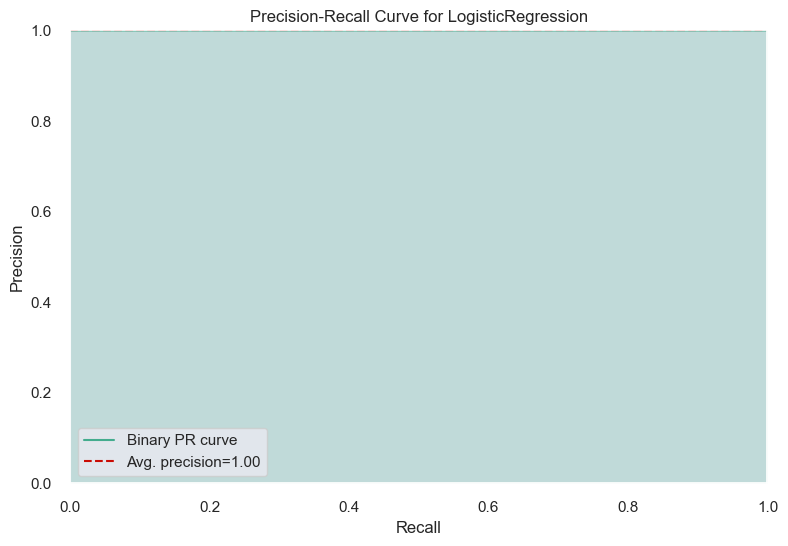

<AxesSubplot:title={'center':'Precision-Recall Curve for LogisticRegression'}, xlabel='Recall', ylabel='Precision'>

In [51]:
prc_logreg = PrecisionRecallCurve(logreg)
prc_logreg.fit(X_train, y_train)
prc_logreg.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_logreg.show()

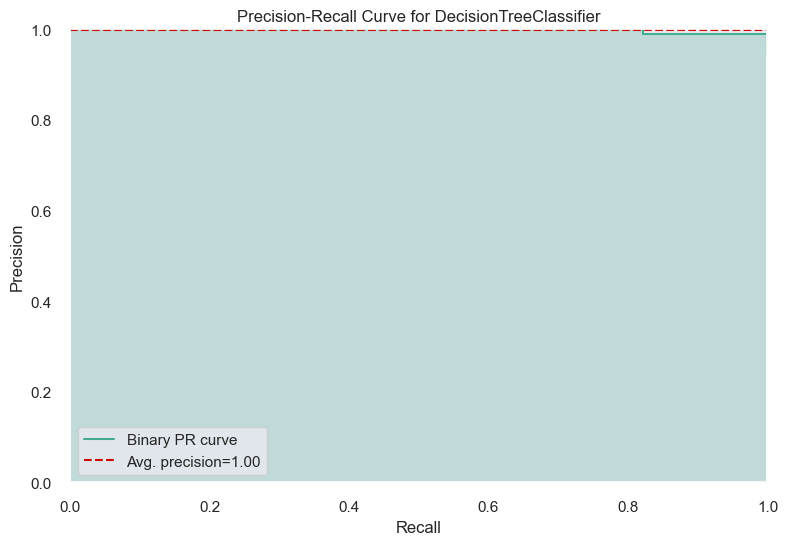

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [52]:
prc_dtc = PrecisionRecallCurve(dtc)
prc_dtc.fit(X_train, y_train)
prc_dtc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_dtc.show()

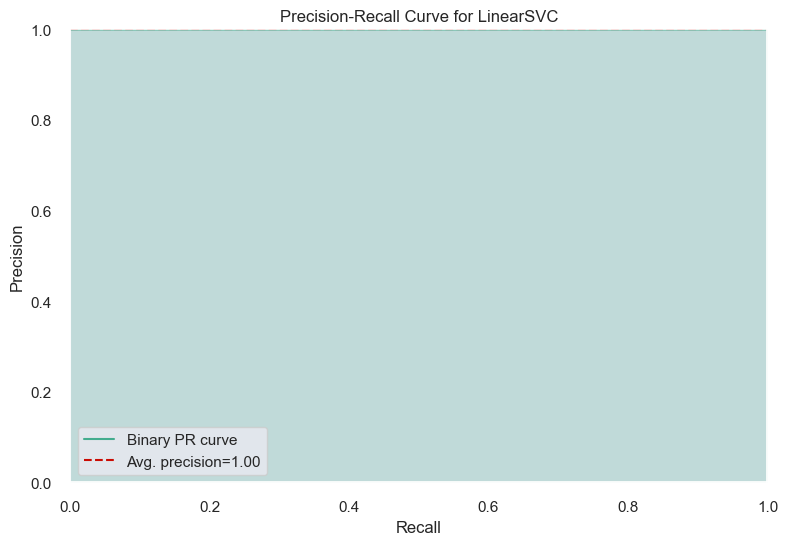

<AxesSubplot:title={'center':'Precision-Recall Curve for LinearSVC'}, xlabel='Recall', ylabel='Precision'>

In [53]:
prc_lsvc = PrecisionRecallCurve(lsvc)
prc_lsvc.fit(X_train, y_train)
prc_lsvc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_lsvc.show()

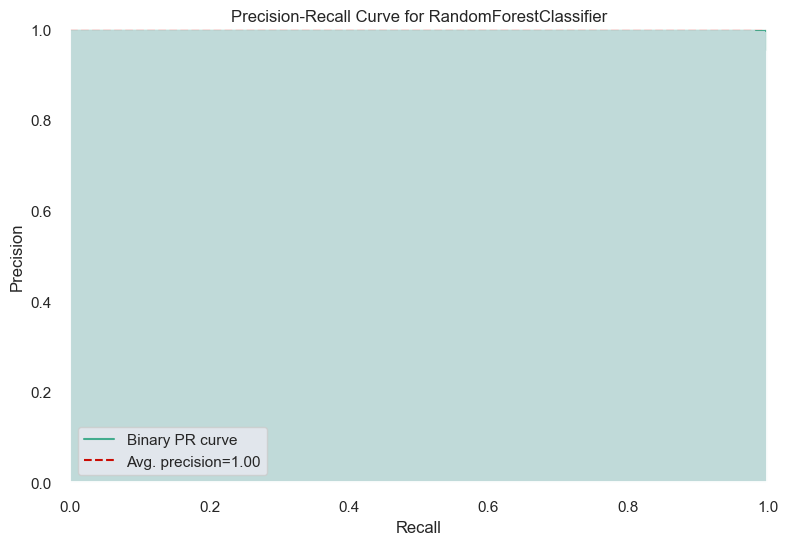

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [54]:
prc_rfc = PrecisionRecallCurve(rfc)
prc_rfc.fit(X_train, y_train)
prc_rfc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_rfc.show()

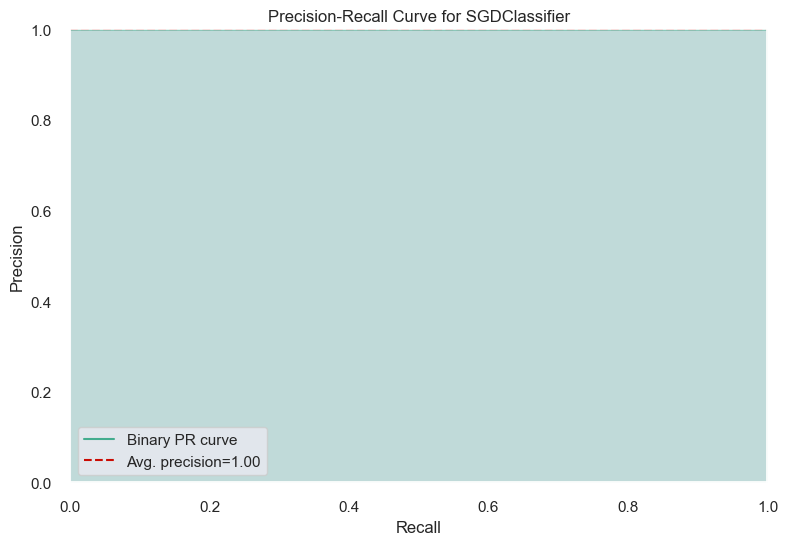

<AxesSubplot:title={'center':'Precision-Recall Curve for SGDClassifier'}, xlabel='Recall', ylabel='Precision'>

In [55]:
prc_sgdc = PrecisionRecallCurve(sgdc)
prc_sgdc.fit(X_train, y_train)
prc_sgdc.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_sgdc.show()

In [ ]:
prc_mnb = PrecisionRecallCurve(mnb)
prc_mnb.fit(X_train, y_train)
prc_mnb.score(X_test, y_test)
plt.legend(loc='lower right', fontsize=12)
prc_mnb.show()

### Validation curve

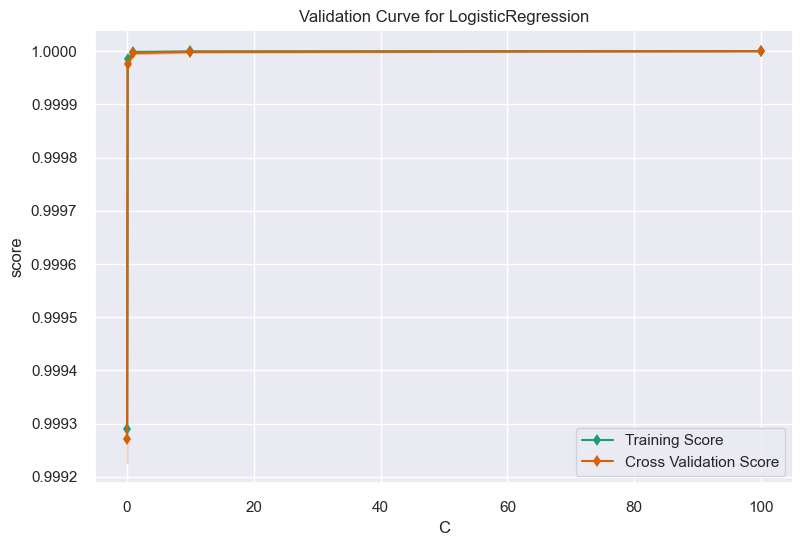

<AxesSubplot:title={'center':'Validation Curve for LogisticRegression'}, xlabel='C', ylabel='score'>

In [56]:
param_range = [0.01,0.1,1.0,10,100]
viz_lgr = ValidationCurve(
    LogisticRegression(random_state=seed), param_name="C",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz_lgr.fit(X_train, y_train)
viz_lgr.show()

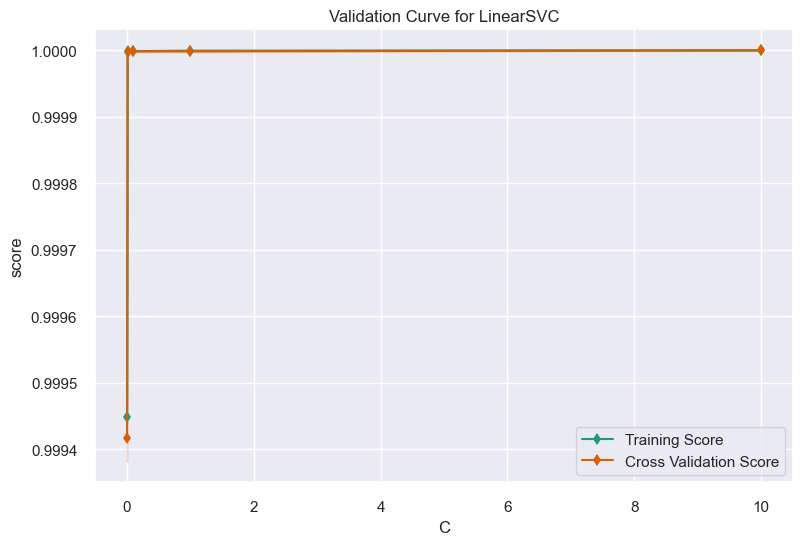

<AxesSubplot:title={'center':'Validation Curve for LinearSVC'}, xlabel='C', ylabel='score'>

In [57]:
param_range = [0.001,0.01,0.1,1.0,10]
viz_lsvc = ValidationCurve(
    LinearSVC(dual=False, random_state=seed), param_name="C",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz_lsvc.fit(X_train, y_train)
viz_lsvc.show()

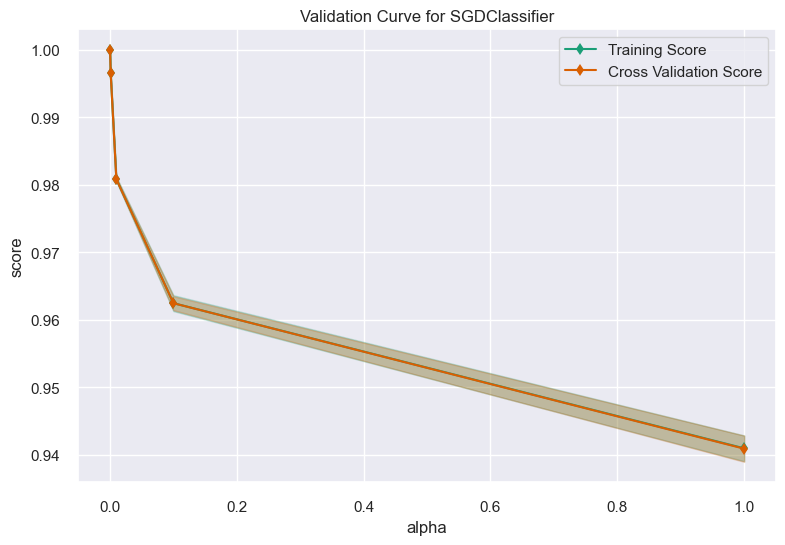

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='alpha', ylabel='score'>

In [58]:
param_range = [0.0001,0.001,0.01,0.1,1.0]
viz_sgdc = ValidationCurve(
    SGDClassifier(max_iter=1500,random_state=seed), param_name="alpha",
    param_range=param_range, cv=5, scoring="f1_weighted"
)

# Fit and show the visualizer
viz_sgdc.fit(X_train, y_train)
viz_sgdc.show()

## Decision regions Vizualizer from mlextend

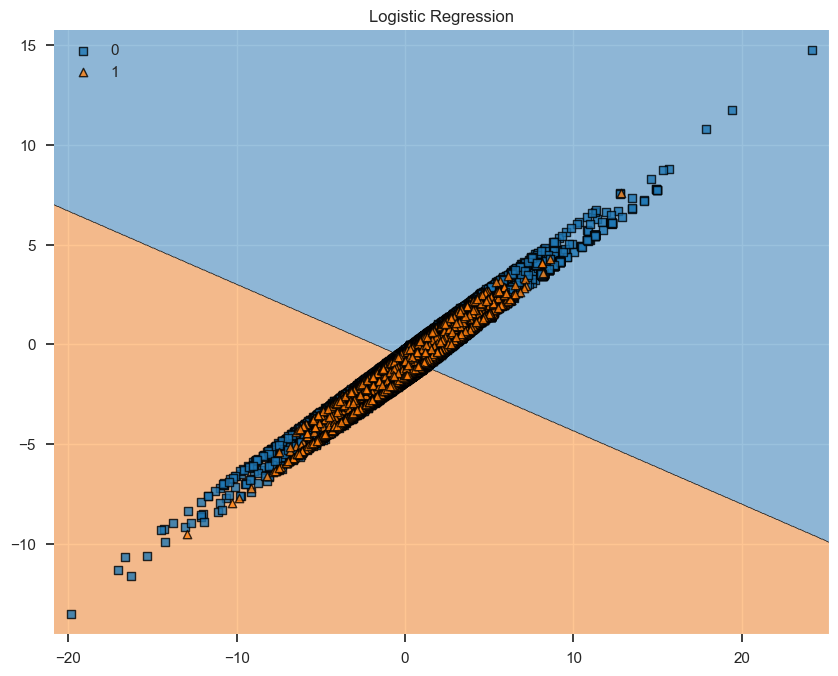

In [59]:
y = np.array(y_train, dtype = np.uint)
#features will be reduce, X/y will be changed, recommend loading saved models so that previous model fit will not have to be re-ran
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

svd_log_reg = logreg
svd_log_reg.fit(X, y)

fig = plot_decision_regions(X=X, y=y, clf=svd_log_reg, legend=2)
plt.title('Logistic Regression')

plt.show()

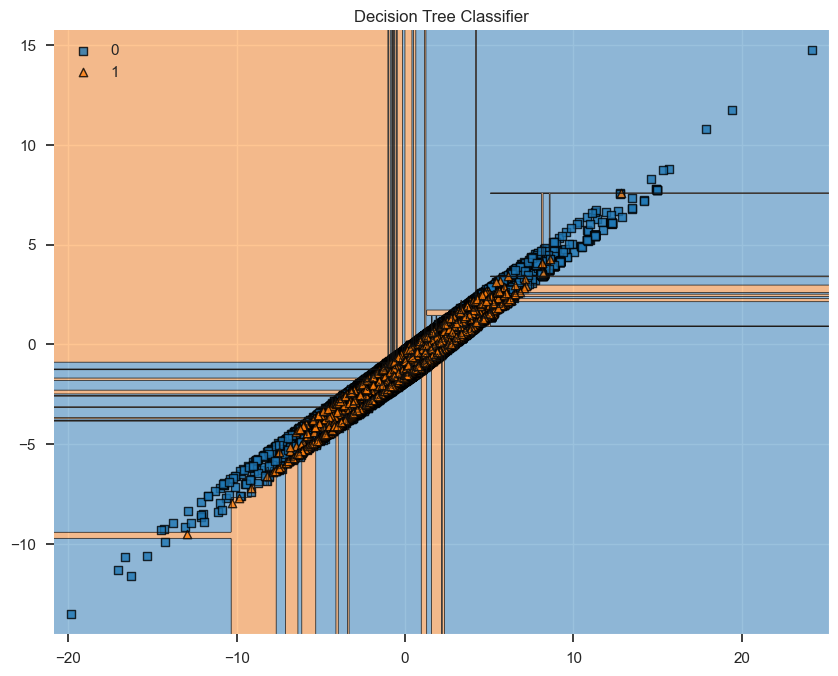

In [60]:
y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

svd_dtc = dtc
svd_dtc.fit(X, y)

fig = plot_decision_regions(X=X, y=y, clf=svd_dtc, legend=2)
plt.title('Decision Tree Classifier')

plt.show()

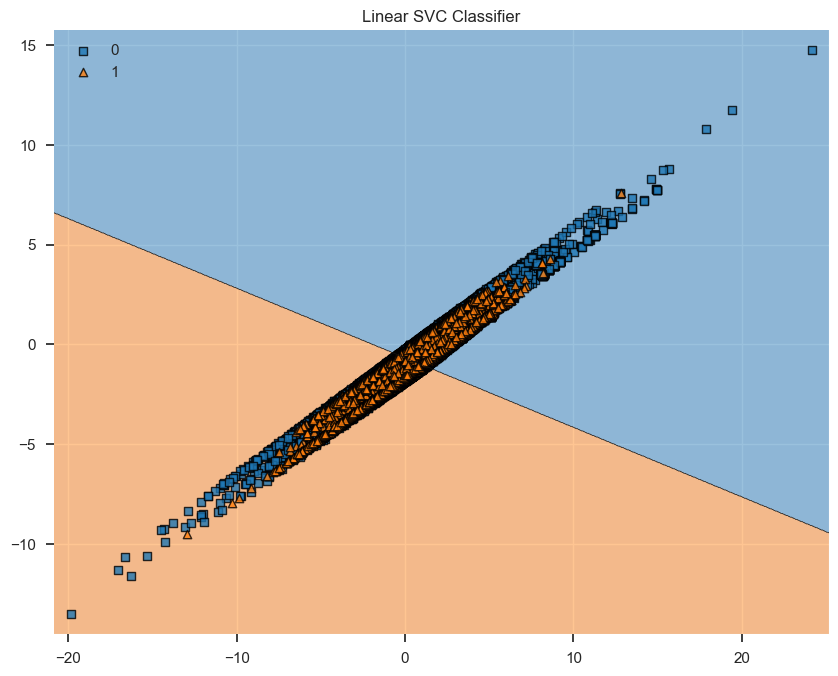

In [61]:
%%time

y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

svd_lsvc = lsvc
svd_lsvc.fit(X, y)

fig = plot_decision_regions(X=X, y=y, clf=svd_lsvc, legend=2)
plt.title('Linear SVC Classifier')

plt.show()

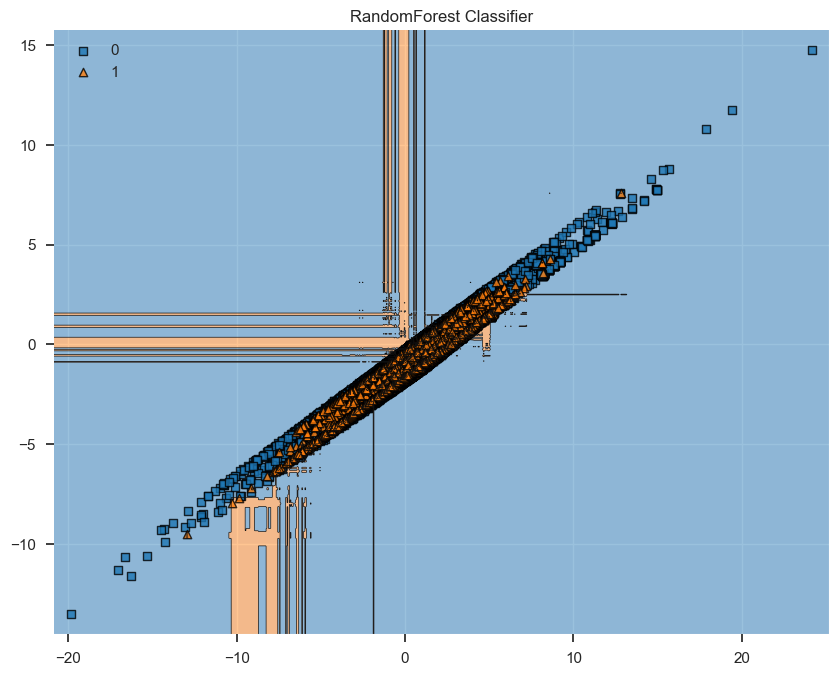

In [63]:
%%time

y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))

svd_rfc = rfc
svd_rfc.fit(X, y)


fig = plot_decision_regions(X=X, y=y, clf=svd_rfc, legend=2)
plt.title('RandomForest Classifier')

plt.show()

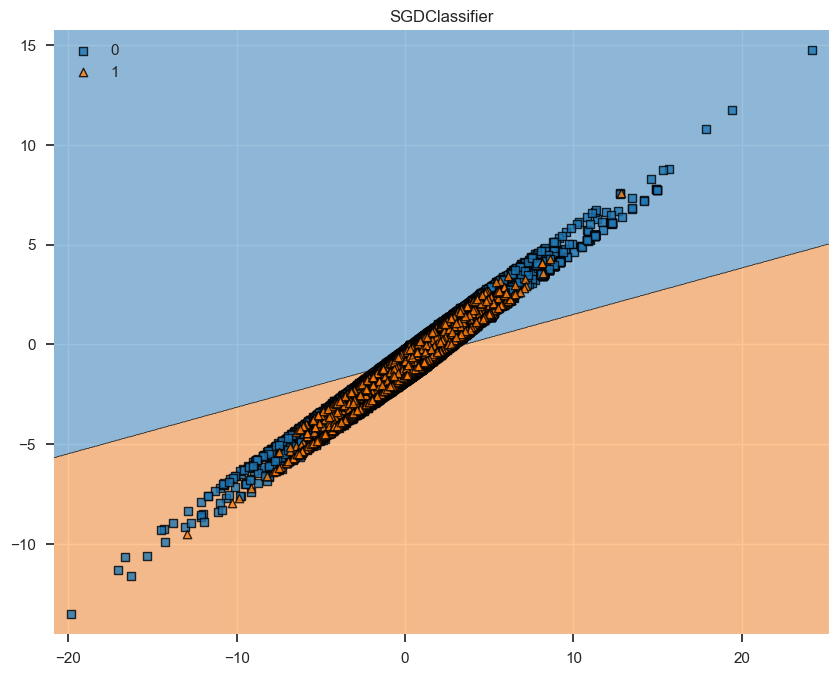

In [64]:
%%time

y = np.array(y_train, dtype = np.uint)
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=seed)
X = svd.fit_transform(X_train)

# Plotting Decision Regions

fig = plt.figure(figsize=(10, 8))


svd_sgdc = sgdc
svd_sgdc.fit(X, y)

fig = plot_decision_regions(X=X, y=y, clf=svd_sgdc, legend=2)
plt.title('SGDClassifier')

plt.show()

### Nayevis Bayes Model

In [103]:
target_mnb = df.label
features_mnb = df[['domain', 'title', 'content', 'c_word_count',
       't_word_count', 'c_character_count', 't_character_count',
       'c_avg_word_length', 't_avg_word_length', 'title_sentiment_label']].copy()

In [104]:
#recommend c
X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb = train_test_split(features_mnb, target_mnb, test_size = 0.2, random_state=seed)
print(df.shape); print(X_train_mnb.shape); print(X_test_mnb.shape)

(1781665, 13)
(1425332, 10)
(356333, 10)


### Column Transformer for MNB model. It is neccesary to take out "negative_valus" which includes ['content_affin'] as this feature has negative values which can not be input into MNB model

In [100]:
%%time

#Important:  pass the columns as string to CountVectorizer/TfifVectorizer and list of columns (even list of one column) to 
# OneHotEncoding (OHE) to make it work
# min max https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#robust https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
ct_mnb = ColumnTransformer(
    [('num', MinMaxScaler(), numerical),
     ('title_sentiment_label', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['title_sentiment_label']),
     ('domain', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['domain']),
     ('title', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'title'),
     ('content', TfidfVectorizer(max_features = 6000, stop_words = 'english', ngram_range=(1,1)), 'content')], n_jobs=3, verbose=True)

In [106]:
%%time
# Creating the feature matrix
X_train_mnb = ct_mnb.fit_transform(X_train_mnb)
X_test_mnb = ct_mnb.transform(X_test_mnb)
print(f'Shape of Term Frequency Matrix of train: {X_train_mnb.shape}')
print(f'Shape of Term Frequency Matrix of test: {X_test_mnb.shape}')

Shape of Term Frequency Matrix of train: (1425332, 12162)
Shape of Term Frequency Matrix of test: (356333, 12162)
CPU times: user 25.3 s, sys: 1min 8s, total: 1min 33s
Wall time: 7min 56s


## Encode the target

In [107]:
%%time

Encoder = LabelEncoder()
y_train_mnb = Encoder.fit_transform(y_train_mnb)
y_test_mnb = Encoder.fit_transform(y_test_mnb)
print(y_train_mnb.shape); print(y_test_mnb.shape)

(1425332,)
(356333,)
CPU times: user 221 ms, sys: 53.7 ms, total: 275 ms
Wall time: 296 ms


In [108]:
classes = Encoder.classes_
classes

array(['fake', 'real'], dtype=object)

In [109]:
%%time
# MultinomialNB
mnb = MultinomialNB()
# Training the model 
mnb.fit(X_train_mnb, y_train_mnb) 

#Predict the Test using MultinominalNB
y_pred_mnb = mnb.predict(X_test_mnb)

CPU times: user 1.33 s, sys: 1.82 s, total: 3.15 s
Wall time: 3.61 s


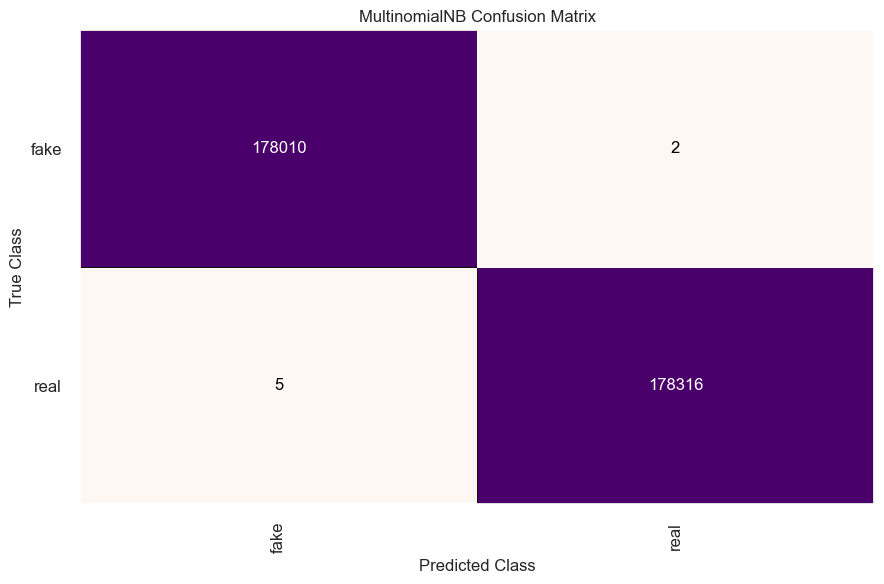

CPU times: user 1.67 s, sys: 332 ms, total: 2.01 s
Wall time: 1.72 s


<AxesSubplot:title={'center':'MultinomialNB Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [110]:
%%time

cm_mnb = ConfusionMatrix(mnb, classes=classes, cmap='RdPu')
cm_mnb.fit(X_train_mnb, y_train_mnb)
cm_mnb.score(X_test_mnb, y_test_mnb)
cm_mnb.show()